# Time series analysis on AWS
*Chapter 3 - Creating a project and ingesting your data*

## Initializations
---

In [1]:
# !pip install --quiet tqdm kaggle tsia

### Imports

In [1]:
import matplotlib.colors as mpl_colors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
# import tsia
import warnings
# import zipfile

from matplotlib import gridspec
# from sklearn.preprocessing import normalize
# from tqdm import tqdm
# from urllib.request import urlretrieve

### Parameters

In [3]:
RAW_DATA = os.path.join('..', 'Data', 'raw')
DATA = os.path.join('..', 'Data')
warnings.filterwarnings("ignore")
os.makedirs(RAW_DATA, exist_ok=True)

%matplotlib inline
# plt.style.use('Solarize_Light2')
plt.style.use('fivethirtyeight')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['lines.linewidth'] = 0.3
plt.rcParams['axes.titlesize'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 4
plt.rcParams['ytick.labelsize'] = 4
plt.rcParams['grid.linewidth'] = 0.2
plt.rcParams['legend.fontsize'] = 5

### Helper functions

### Downloading datasets

#### **Dataset 5:** London household energy consumption with weather data

In [13]:
FILE_NAME    = 'smart-meters-in-london.zip'
ARCHIVE_PATH = os.path.join(RAW_DATA, FILE_NAME)
FILE_PATH    = os.path.join(DATA, 'energy-london', 'smart-meters-in-london.zip')
FILE_DIR     = os.path.dirname(FILE_PATH)

# Checks if the data were already downloaded:
if os.path.exists(os.path.join(DATA, 'energy-london', 'acorn_details.csv')):
    print("File found, skipping download")
    
else:
    # Downloading and unzipping datasets from Kaggle:
    print("Downloading dataset (2.26G), can take a few minutes depending on your connection")
    os.makedirs(os.path.join(DATA, 'energy-london'), exist_ok=True)
    !kaggle datasets download -d jeanmidev/smart-meters-in-london -p $RAW_DATA
    
    print('Unzipping files...')
    zip_ref = zipfile.ZipFile(ARCHIVE_PATH, 'r')
    zip_ref.extractall(FILE_DIR + '/')
    zip_ref.close()
    
    !rm $DATA/energy-london/*zip
    !rm $DATA/energy-london/*gz
    !mv $DATA/energy-london/halfhourly_dataset/halfhourly_dataset/* $DATA/energy-london/halfhourly_dataset
    !rm -Rf $DATA/energy-london/halfhourly_dataset/halfhourly_dataset
    !mv $DATA/energy-london/daily_dataset/daily_dataset/* $DATA/energy-london/daily_dataset
    !rm -Rf $DATA/energy-london/daily_dataset/daily_dataset

100%|█████████████████████████████████████▊| 2.25G/2.26G [00:35<00:00, 95.7MB/s]
100%|██████████████████████████████████████| 2.26G/2.26G [00:45<00:00, 53.3MB/s]
Unzipping files...


## Dataset visualization
---

### **5.** London household energy consumption with weather data

We want to filter out households that are are subject to the dToU tariff and keep only the ones with a known ACORN (i.e. not in the ACORN-U group): this will allow us to better model future analysis by adding the Acorn detail informations (which by definitions, won't be available for the ACORN-U group).

In [48]:
household_filename = os.path.join(DATA, 'energy-london', 'informations_households.csv')
household_df = pd.read_csv(household_filename)
household_df = household_df[(household_df['stdorToU'] == 'Std') & (household_df['Acorn'] == 'ACORN-E')]
print(household_df.shape)
household_df.head()

(1228, 5)


,LCLid,stdorToU,Acorn,Acorn_grouped,file
627,MAC002543,Std,ACORN-E,Affluent,block_12
628,MAC002556,Std,ACORN-E,Affluent,block_12
629,MAC002660,Std,ACORN-E,Affluent,block_12
630,MAC005399,Std,ACORN-E,Affluent,block_12
631,MAC002545,Std,ACORN-E,Affluent,block_12


#### Associating households with they energy consumption data
Each household (with an ID starting by `MACxxxxx` in the table above) has its consumption data stored in a block file name `block_xx`. This file is also available from the `informations_household.csv` file extracted above. We have the association between `household_id` and `block_file`: we can open each of them and keep the consumption for the households of interest. All these data will be concatenated into an `energy_df` dataframe:

In [49]:
%%time

household_ids = household_df['LCLid'].tolist()
consumption_file = os.path.join(DATA, 'energy-london', 'hourly_consumption.csv')
min_data_points = ((pd.to_datetime('2020-12-31') - pd.to_datetime('2020-01-01')).days + 1)*24*2

if os.path.exists(consumption_file):
    print('Half-hourly consumption file already exists, loading from disk...')
    energy_df = pd.read_csv(consumption_file)
    energy_df['timestamp'] = pd.to_datetime(energy_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
    print('Done.')
    
else:
    print('Half-hourly consumption file not found. We need to generate it.')
    
    # We know have the block number we can use to open the right file:
    energy_df = pd.DataFrame()
    target_block_files = household_df['file'].unique().tolist()
    print('- {} block files to process: '.format(len(target_block_files)), end='')
    df_list = []
    for block_file in tqdm(target_block_files):
        # Reads the current block file:
        current_filename = os.path.join(DATA, 'energy-london', 'halfhourly_dataset', '{}.csv'.format(block_file))
        df = pd.read_csv(current_filename)
        
        # Set readable column names and adjust data types:
        df.columns = ['household_id', 'timestamp', 'energy']
        df = df.replace(to_replace='Null', value=0.0)
        df['energy'] = df['energy'].astype(np.float64)
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
        
        # We filter on the households sampled earlier:
        df_list.append(df[df['household_id'].isin(household_ids)].reset_index(drop=True))
    
    # Concatenate with the main dataframe:
    energy_df = pd.concat(df_list, axis='index', ignore_index=True)
    
    datapoints = energy_df.groupby(by='household_id').count()
    datapoints = datapoints[datapoints['timestamp'] < min_data_points]
    hhid_to_remove = datapoints.index.tolist()
    energy_df = energy_df[~energy_df['household_id'].isin(hhid_to_remove)]

    # Let's save this dataset to disk, we will use it from now on:
    print('Saving file to disk... ', end='')
    energy_df.to_csv(consumption_file, index=False)
    print('Done.')

  0%|          | 0/32 [00:00<?, ?it/s]

Half-hourly consumption file not found. We need to generate it.
- 32 block files to process: 

100%|██████████| 32/32 [00:43<00:00,  1.37s/it]


Saving file to disk... Done.
CPU times: user 2min 38s, sys: 4.24 s, total: 2min 42s
Wall time: 2min 52s


In [50]:
start = np.min(energy_df['timestamp'])
end = np.max(energy_df['timestamp'])
weather_filename = os.path.join(DATA, 'energy-london', 'weather_hourly_darksky.csv')

weather_df = pd.read_csv(weather_filename)
weather_df['time'] = pd.to_datetime(weather_df['time'], format='%Y-%m-%d %H:%M:%S')
weather_df = weather_df.drop(columns=['precipType', 'icon', 'summary'])
weather_df = weather_df.sort_values(by='time')
weather_df = weather_df.set_index('time')
weather_df = weather_df[start:end]

# Let's make sure we have one datapoint per hour to match 
# the frequency used for the household energy consumption data:
weather_df = weather_df.resample(rule='1H').mean()     # This will generate NaN values timestamp missing data
weather_df = weather_df.interpolate(method='linear')   # This will fill the missing values with the average 

print(weather_df.shape)
weather_df

(19863, 8)


,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
time,,,,,,,,
2011-11-23 10:00:00,6.24,233.0,5.74,5.46,1027.67,4.24,1.99,0.98
2011-11-23 11:00:00,10.20,233.0,7.67,5.74,1027.56,5.94,2.66,0.88
2011-11-23 12:00:00,11.62,234.0,8.84,6.52,1027.24,7.25,2.80,0.85
2011-11-23 13:00:00,12.68,233.0,9.87,6.99,1027.35,8.29,3.12,0.82
2011-11-23 14:00:00,12.25,232.0,10.36,7.75,1027.25,10.36,3.26,0.84
...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,14.03,220.0,5.94,2.07,1006.74,3.47,3.25,0.76
2014-02-27 21:00:00,16.09,217.0,5.03,1.67,1006.36,2.50,3.06,0.79
2014-02-27 22:00:00,14.00,216.0,4.10,1.64,1005.67,1.41,3.02,0.84


In [51]:
energy_df = energy_df.set_index(['household_id', 'timestamp'])
energy_df

energy
household_id timestamp                  
MAC002542    2012-07-09 11:30:00   0.037
             2012-07-09 12:00:00   0.106
             2012-07-09 12:30:00   0.094
             2012-07-09 13:00:00   0.196
             2012-07-09 13:30:00   0.281
...                                  ...
MAC001938    2014-02-27 22:00:00   0.030
             2014-02-27 22:30:00   0.030
             2014-02-27 23:00:00   0.032
             2014-02-27 23:30:00   0.033
             2014-02-28 00:00:00   0.033

[37645656 rows x 1 columns]

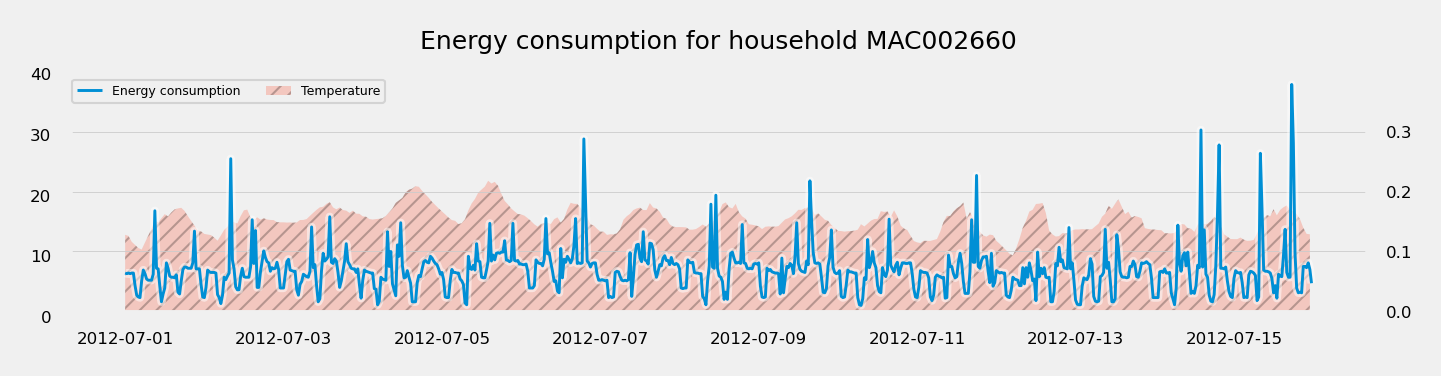

In [60]:
hhid = household_ids[2]
hh_energy = energy_df.loc[hhid, :]
start = '2012-07-01'
end = '2012-07-15'

fig = plt.figure(figsize=(5,1))
ax1 = fig.add_subplot(1,1,1)
plot2 = ax1.fill_between(
    x=weather_df.loc[start:end, 'temperature'].index, 
    y1=0.0, 
    y2=weather_df.loc[start:end, 'temperature'], 
    color=colors[1], 
    linewidth=0.0,
    edgecolor='#000000',
    alpha=0.25, 
    hatch="//////", 
    label='Temperature'
)
ax1.set_ylim((0,40))
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(hh_energy[start:end], label='Energy consumption', linewidth=2, color='#FFFFFF', alpha=0.5)
plot1 = ax2.plot(hh_energy[start:end], label='Energy consumption', linewidth=0.7)
ax2.set_title(f'Energy consumption for household {hhid}')

labels = [plot1[0].get_label(), plot2.get_label()]
plt.legend(handles=[plot1[0], plot2], labels=labels, loc='upper left', fontsize=3, ncol=2)

plt.show()

In [61]:
acorn_filename = os.path.join(DATA, 'energy-london', 'acorn_details.csv')
acorn_df = pd.read_csv(acorn_filename, encoding='ISO-8859-1')
acorn_df = acorn_df.sample(10).loc[:, ['MAIN CATEGORIES', 'CATEGORIES', 'REFERENCE', 'ACORN-A', 'ACORN-B', 'ACORN-E']]
acorn_df

,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-E
134,TRANSPORT,Travel To Work,Work mainly at or from home,230.0,156.0,91.0
596,DIGITAL,Sites regularly visited,Groupon,103.0,103.0,123.0
66,FAMILY,Children in household,Children at home : 0,106.0,101.0,97.0
586,DIGITAL,Sites regularly visited,Direct.gov.uk,104.0,107.0,99.0
341,DIGITAL,Social Media Brands (used at least weekly),Tinder,297.0,81.0,211.0
817,LEISURE TIME,Holiday Destination/Type,USA / Canada,2280.0,344.0,56.0
818,LEISURE TIME,Holiday Destination/Type,Caribbean,133.0,150.0,128.0
701,ENVIRONMENT,Action,Rarely Leave TV or PC on standby for long peri...,102.0,100.0,92.0
51,HOUSING,House Value,House Value up to 100k,13.0,17.0,40.0
73,FAMILY,Household Size,Household size : 5+ persons,128.0,104.0,100.0
